# Conduct reversal tests on directional data in MagIC format using PmagPy

## Introduction

This notebook is a template for importing data and conducting a reversal test using PmagPy. You can use it on any MagIC contribution with dual polarity site data. The example that is given is on paleomagnetic directional data from the following study that is in the MagIC database (https://earthref.org/MagIC/19903):

> Hong Ao, Zhisheng An, Mark J. Dekkers, Yongxiang Li, Guoqiao Xiao, Hui Zhao, Xiaoke Qiang (2013). Pleistocene magnetochronology of the fauna and Paleolithic sites in the Nihewan Basin: Significance for environmental and hominin evolution in North China. Quaternary Geochronology 18:78-92. doi:10.1016/J.QUAGEO.2013.06.004.

### Change the MagIC contribution

You can change what study this notebook is applied to by changing the `magic_id` in the **Download data and unpack data** code cell below.

### Apply to your own `sites.txt` data

You can also substitute in your own MagIC format `sites.txt` file. To do this, skip the **Download data and unpack data** section and go to the **Import the sites table** section after running the **Import packages** code.

## Import packages

In [1]:
import pmagpy.ipmag as ipmag
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Download and unpack data

### Download MagIC contribution

We can first download the data from MagIC by providing the `magic_id`.
If the directory name that is given is not provided, it will be created.
In the example, the data are put into a folder within this directory that is named `reversal_test_data`.

In [2]:
magic_id='19903'
directory = './reversal_test_data'
result, magic_file_path = ipmag.download_magic_from_id(magic_id, directory=directory)

### Unpack the MagIC file

MagIC contributions are made up of distinct tables that can be unpacked. In this case, we are going to do a reversal test on the site level data so we are particularly interested in unpacking the `sites.txt` table from the MagIC file.

In [3]:
ipmag.unpack_magic(magic_file_path,dir_path=directory, print_progress=False)

1  records written to file  /Users/unimos/0000_Github/PmagPy-docs/example_notebooks/template_notebooks/reversal_test_data/contribution.txt
1  records written to file  /Users/unimos/0000_Github/PmagPy-docs/example_notebooks/template_notebooks/reversal_test_data/locations.txt
214  records written to file  /Users/unimos/0000_Github/PmagPy-docs/example_notebooks/template_notebooks/reversal_test_data/sites.txt
214  records written to file  /Users/unimos/0000_Github/PmagPy-docs/example_notebooks/template_notebooks/reversal_test_data/samples.txt
214  records written to file  /Users/unimos/0000_Github/PmagPy-docs/example_notebooks/template_notebooks/reversal_test_data/specimens.txt


True

### Import the sites table

We can now use pandas to import the sites table to a pandas dataframe using the function `pd.read_csv()`.

We need to point `pd.read_csv()` to the file which with the above steps has the location and name of `'reversal_test/sites.txt'`. This can be changed if the file is in a different place or has a different name. For example, if it is in the same directory as the notebook it can be: `'sites.txt'`

In [4]:
# change the sites_file path if you want to use a file in a different directory
sites_file = directory + '/sites.txt'
sites = pd.read_csv(sites_file,sep='\t',header=1)
sites.head()

,age_high,age_low,age_unit,citations,dir_dec,dir_inc,dir_tilt_correction,geologic_classes,geologic_types,height,lat,lithologies,location,lon,method_codes,site,vgp_lat
0,0,3,Ma,10.1016/j.quageo.2013.06.004,353.6,46.3,100,Sedimentary,Sediment Layer,-0.0,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,0.0,76.399711
1,0,3,Ma,10.1016/j.quageo.2013.06.004,2.6,59.7,100,Sedimentary,Sediment Layer,-2.3,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,2.3,87.978299
2,0,3,Ma,10.1016/j.quageo.2013.06.004,347.7,60.6,100,Sedimentary,Sediment Layer,-3.3,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,3.3,80.596793
3,0,3,Ma,10.1016/j.quageo.2013.06.004,338.2,44.2,100,Sedimentary,Sediment Layer,-4.3,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,4.3,66.955595
4,0,3,Ma,10.1016/j.quageo.2013.06.004,348.6,33.6,100,Sedimentary,Sediment Layer,-5.0,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,5.0,66.113052


### Filter by tilt correction

When there are data in both geographic coordinates (without correction for bedding tilt) and data in tilt corrected coordinates, they each get their own row with different values in the `dir_tilt_correction` column:

- 0: No tilt correction applied. The data are in the geographic coordinate system (i.e., as they are currently oriented in the field).
- 100: Full (100%) tilt correction applied. The data are in the paleohorizontal coordinate system, meaning they have been corrected for tilting to represent their original horizontal position. 

In the example dataset, only the tilt-corrected values are available. As a result, all the entries have a `dir_tilt_correction` of 100. 
For completeness, we will filter and make a `sites_geo` dataframe where `dir_tilt_correction` is 0 and 
a `sites_tc` dataframe where `dir_tilt_correction` is 100. For this example, `sites_geo` will be empty, but 
it will be populated for a MagIC contribution where there are data in those coordinates.

In [5]:
sites_geo = sites[sites['dir_tilt_correction'] == 0]
sites_tc = sites[sites['dir_tilt_correction'] == 100]

### Make declination/inclination lists

We can extract specific columns from the dataframe by using the nomenclature `dataframe_name['column_name']`. In this case, we want to conduct a reversal test on the data in the `sites_geo` dataframe and are interested in the directional data which are the declination column `dir_dec` and the inclination column `dir_inc`. So using the code `sites['dir_dec']` will give us all the declinations which we can assign to a variable `sites_dec`.

If you wanted to do the test on the `sites_tc` data, you would switch in `sites_tc` for `sites_geo` in the text below.

In [6]:
sites_dec = sites_tc['dir_dec']
sites_inc = sites_tc['dir_inc']

## Plot the directions

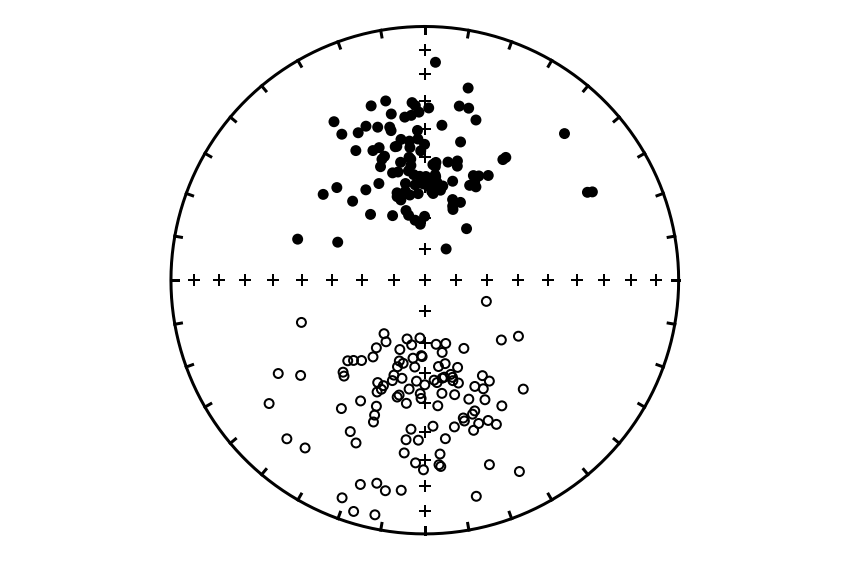

In [7]:
ipmag.plot_net()
ipmag.plot_di(sites_dec,sites_inc)

## Reversal tests

Now that we have extracted the declination and inclination values, let's conduct reversal tests on these data using the functions `ipmag.reversal_test_bootstrap` and `ipmag.reversal_test_MM1990`.

### Conduct the Watson common mean reversal test

We can do the Watson common mean test (together with McFadden and McElhinny (1990) classification) as well:

Results of Watson V test: 

Watson's V:           4.4
Critical value of V:  6.0
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 4.4
Critical angle for M&M1990:   5.1
The McFadden and McElhinny (1990) classification for
this test is: 'B'


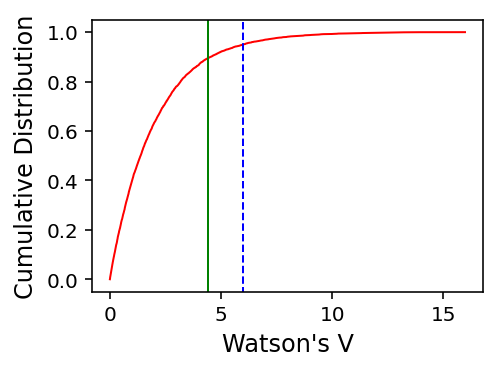

(1, 4.362992887306586, 5.081179945208339, 'B')

In [8]:
ipmag.reversal_test_MM1990(dec=sites_dec,
                           inc=sites_inc,
                           plot_CDF=True)

### Conduct the classic Tauxe et al. (1991) bootstrap reversal test

Let's go ahead and do the bootstrap reversal test using this `ipmag.reversal_test_bootstrap()` function.

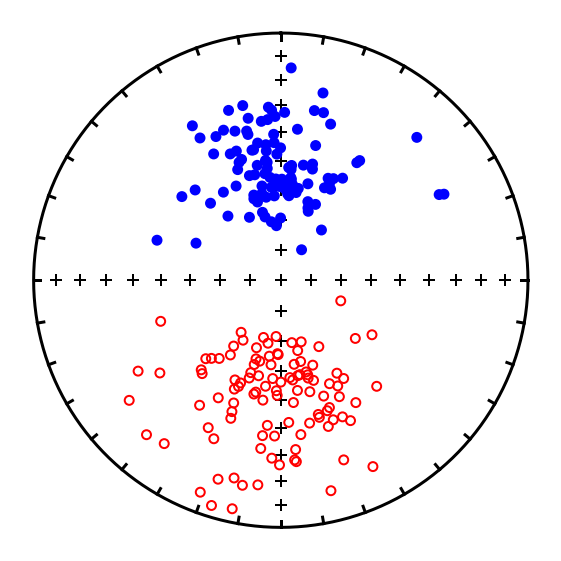

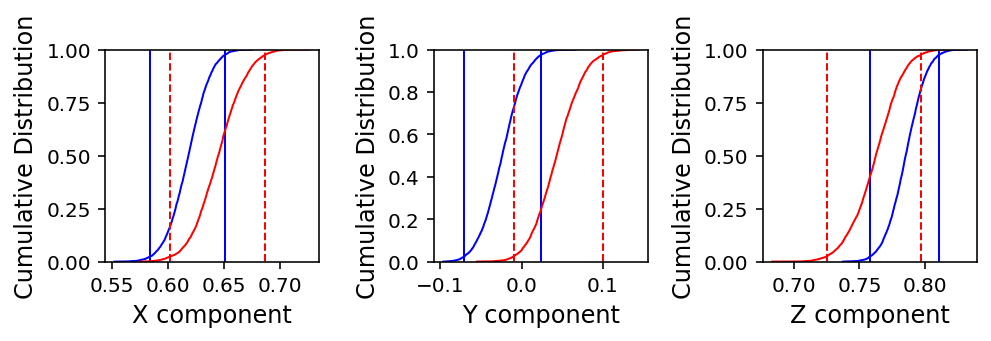

Pass


1

In [9]:
ipmag.reversal_test_bootstrap(dec=sites_dec,
                              inc=sites_inc,
                              plot_stereo = True,
                              save=True,
                              save_folder=directory)

### Apply the updated Heslop et al. (2023) bootstrap reversal test

In the framework of the bootstrap reversal above Tauxe et al. (1991) inference comes from comparing the bootstrap-derived confidence regions for the mean directions. Heslop et al. (2023) updated the test and placed it within a null hypothesis significance testing framework. 

### Learn about the reversal test functions

To learn more about the function we can type the function with a question mark after them in a code cell: `ipmag.reversal_test_bootstrap?` in a code cell.

In [10]:
ipmag.reversal_test_bootstrap?

Signature:
ipmag.reversal_test_bootstrap(
    dec=None,
    inc=None,
    di_block=None,
    plot_stereo=False,
    color1='blue',
    color2='red',
    save=False,
    save_folder='.',
    fmt='svg',
)
Docstring:
Conduct a reversal test using bootstrap statistics (Tauxe, 2010) to
determine whether two populations of directions could be from an antipodal
common mean.

Parameters:
    dec: list of declinations
    inc: list of inclinations
    di_block: a nested list of [dec,inc]
        A di_block can be provided in which case it will be used instead of
        dec, inc lists.
    plot_stereo : before plotting the CDFs, plot stereonet with the
        bidirectionally separated data (default is False)
    save : boolean argument to save plots (default is False)
    save_folder : directory where plots will be saved (default is current directory, '.')
    fmt : format of saved figures (default is 'svg')

Returns:
    A boolean where 0 is fail and 1 is pass is returned. 
    Plots of the c

In [11]:
ipmag.reversal_test_MM1990?

Signature:
ipmag.reversal_test_MM1990(
    dec=None,
    inc=None,
    di_block=None,
    plot_CDF=False,
    plot_stereo=False,
    save=False,
    save_folder='.',
    fmt='svg',
)
Docstring:
Calculates Watson's V statistic from input files through Monte Carlo
simulation in order to test whether normal and reversed populations could
have been drawn from a common mean. Also provides the critical angle between 
the two sample mean directions and the corresponding McFadden and McElhinny 
(1990) classification. This function is a wrapper around the 
ipmag.common_mean_watson() function with the first step of splitting
the data into two polarities using the pmag.flip() function and flipping
the reverse direction to their antipode.

 Parameters:
    dec (list, optional): List of declinations.
    inc (list, optional): List of inclinations.
    di_block (list of lists, optional): Nested list of [dec,inc]. If provided, it 
        takes precedence over separate dec and inc lists.
    plot_CDF

In [29]:
import pmagpy.pmag as pmag
import numpy as np
import matplotlib.pyplot as plt

di_block =  None
dec = sites_dec
inc = sites_inc

if di_block is None:
    all_dirs = ipmag.make_di_block(dec, inc)
else:
    all_dirs = di_block

F1, F2 = pmag.flip(all_dirs)

X1 = np.transpose(pmag.dir2cart(F1)) # normal directions in Cartesian coordinates (one direction per column)
X2 = -np.transpose(pmag.dir2cart(F2)) # inverted reversed directions in Cartesian coordinates

CMDT value = 8.22
CMDT critical value = 12.41
CMDT p-value = 0.14


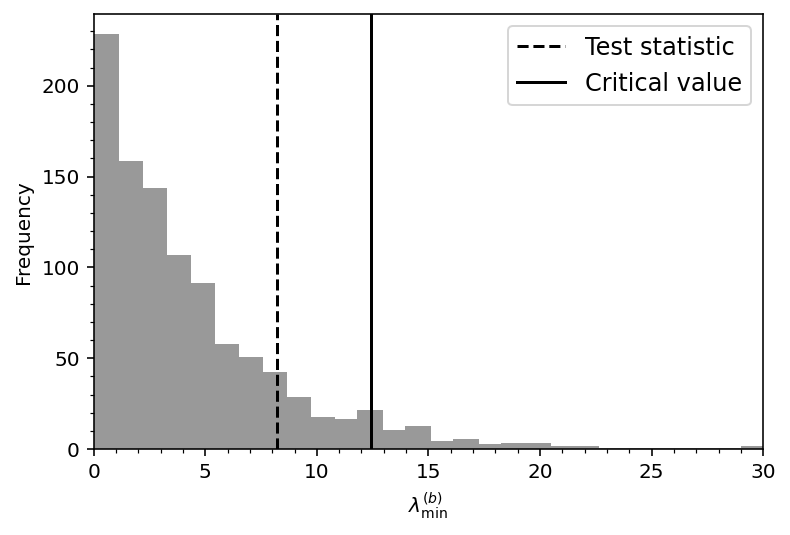

In [31]:
n1 = np.shape(X1)[1] #number of observations in first data set
n2 = np.shape(X2)[1] #number of observations in second data set
n = n1 + n2 #total number of observations

X12 = np.hstack((X1,X2)) #form pooled data set

mhat1 = np.mean(X1,axis=1)
mhat1 /= np.linalg.norm(mhat1) #mean of first data set

mhat2 = np.mean(X2,axis=1)
mhat2 /= np.linalg.norm(mhat2) #mean of second data set

mhat12 = np.mean(X12,axis=1)
mhat12 /= np.linalg.norm(mhat12) #mean of pooled data set

Mhat1 = pmag.form_Mhat(mhat1) #Mhat of first data set
Ghat1 = pmag.form_Ghat(X1,Mhat1) #Ghat of first data set

Mhat2 = pmag.form_Mhat(mhat2) #Mhat of second data set
Ghat2 = pmag.form_Ghat(X2,Mhat2) #Ghat of second data set

Ahat = Mhat1.getH()*np.linalg.inv(Ghat1)*Mhat1
Ahat += Mhat2.getH()*np.linalg.inv(Ghat2)*Mhat2
Ahat *= n

D,V = np.linalg.eig(Ahat)
idx = np.argmin(D)
Lmin = D[idx] #minimum eigenvalue
mhat0 = V[:,idx] #eigenvector corresponding to pooled sample mean

Q1 = pmag.form_Q(mhat0,mhat1) #rotation matrix for first data set
X10 = np.matmul(Q1,X1) #rotated version of first data set

Q2 = pmag.form_Q(mhat0,mhat2) #rotation matrix for second data set
X20 = np.matmul(Q2,X2) #rotated version of second data set

num_sims = 1000 #number of bootstrap iterations
Lmin_b = np.zeros(num_sims) #predefine output array for minimum eigenvalues
T_b = np.zeros(num_sims) ##predefine output array for Tb (equation 11)

for i in range(num_sims): #loop through bootstrap iterations
    idx1 = np.random.randint(0,n1,n1) #select observation indicies with replacement
    X10_b = np.asarray(X10[:,idx1]) #form bootstrap sample from rotated version of first data set
    
    mhat10_b = np.mean(X10_b,axis=1) #mean direction of bootstrap sample
    mhat10_b /= np.linalg.norm(mhat10_b)
    mhat10_b = (np.asarray(mhat10_b)).flatten()
    Mhat10_b = pmag.form_Mhat(mhat10_b) #\hat{M} for bootstrap sample
    Ghat10_b = pmag.form_Ghat(X10_b,Mhat10_b) #\hat{G} for bootstrap sample
    
    idx2 = np.random.randint(0,n2,n2) #select observation indicies with replacement
    X20_b = np.asarray(X20[:,idx2]) #form bootstrap sample from rotated version of second data set
    
    mhat20_b = np.mean(X20_b,axis=1) #mean direction of bootstrap sample
    mhat20_b /= np.linalg.norm(mhat20_b)
    mhat20_b = (np.asarray(mhat20_b)).flatten()
    Mhat20_b = pmag.form_Mhat(mhat20_b) #\hat{M} for bootstrap sample
    Ghat20_b = pmag.form_Ghat(X20_b,Mhat20_b) #\hat{G} for bootstrap sample
    
    Ahat_b = Mhat10_b.getH()*np.linalg.inv(Ghat10_b)*Mhat10_b #bootstrap estimate of \hat{A}_0 (equation 8)
    Ahat_b += Mhat20_b.getH()*np.linalg.inv(Ghat20_b)*Mhat20_b
    Ahat_b *= n
    
    D_b,V_b = np.linalg.eig(Ahat_b) #Eigenvalues and eigenvectors
    Lmin_b[i] = np.min(D_b) #minimum eigenvalue for boostrap sample
    T_b[i] = np.matmul(np.matmul(np.transpose(mhat0),Ahat_b),mhat0) #Bootstrap T for pooled data (equation 11)
    
p = (1+np.sum(Lmin_b>=Lmin))/(num_sims+1) # p-value (step 8 of CMDT, Section 3)
# (n.b., if p > 0.05 cannot reject null of common means at alpha = 0.05)

alpha = 0.05 #set significance level
Lmin_c = np.quantile(Lmin_b,1-alpha) #test critical value
# (n.b., if Lmin > Lmin_c reject null of common means at alpha significance level)

print("CMDT value = {:.2f}".format(Lmin))
print("CMDT critical value = {:.2f}".format(Lmin_c))
print("CMDT p-value = {:.2f}".format(p))

plt.figure()
plt.hist(Lmin_b,bins=int(np.sqrt(num_sims)),color = "0.6", ec="0.6");
axes = plt.gca()
y_min, y_max = axes.get_ylim()
plt.plot([Lmin,Lmin],[y_min,y_max],'--k',label='Test statistic')
plt.plot([Lmin_c,Lmin_c],[y_min,y_max],'-k',label='Critical value')
plt.ylim([y_min,y_max])
x_min, x_max = axes.get_xlim()
plt.xlim([0,30])
plt.xlabel(r'$\lambda_{\rm{min}}^{(b)}$')
plt.ylabel('Frequency')
plt.minorticks_on()
plt.rcParams.update({'font.size': 12})
plt.legend();

